In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd

drive.mount('/content/drive/')
data = pd.read_csv('drive/MyDrive/aggregated_data_10_minute_intervals.csv')

Mounted at /content/drive/


In [ ]:
df = pd.DataFrame()
df[["date", "value"]] = data[["threshold_time_ms", "open"]]
df

,date,value
0,2021-06-01 00:00:00,37260.955
1,2021-06-01 00:10:00,37559.935
2,2021-06-01 00:20:00,37482.405
3,2021-06-01 00:30:00,37731.905
4,2021-06-01 00:40:00,37762.095
...,...,...
15115,2021-09-24 23:10:00,42854.565
15116,2021-09-24 23:20:00,42949.675
15117,2021-09-24 23:30:00,42881.335
15118,2021-09-24 23:40:00,42672.665


In [ ]:
split = int(len(df) * 0.7)
train = df.iloc[:split].value
test = df.iloc[split:].value
print(len(train))
print(len(test))


10584
4536


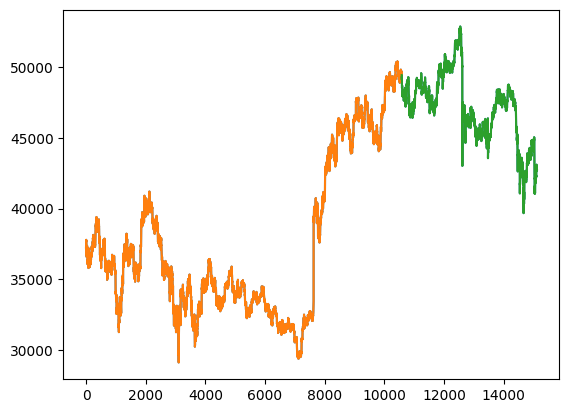

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df.value)
plt.plot(train)
plt.plot(test)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.400094
p-value: 0.910083


In [ ]:
result = adfuller(train.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -35.584282
p-value: 0.000000


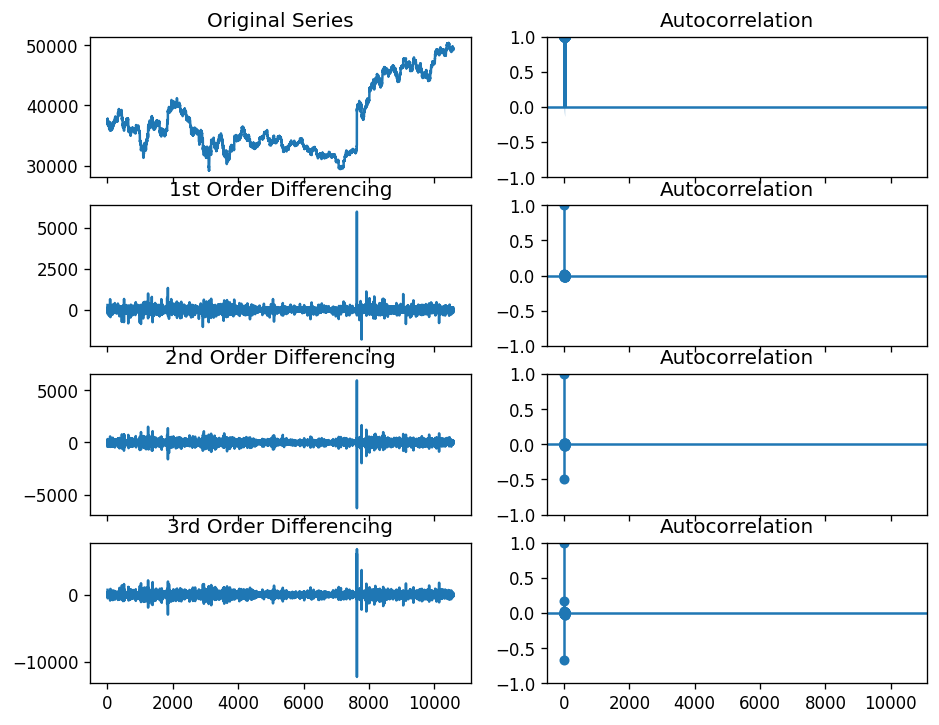

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(train); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.diff().diff().dropna(), ax=axes[2, 1])

axes[3, 0].plot(train.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(train.diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [ ]:
# d = 2

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


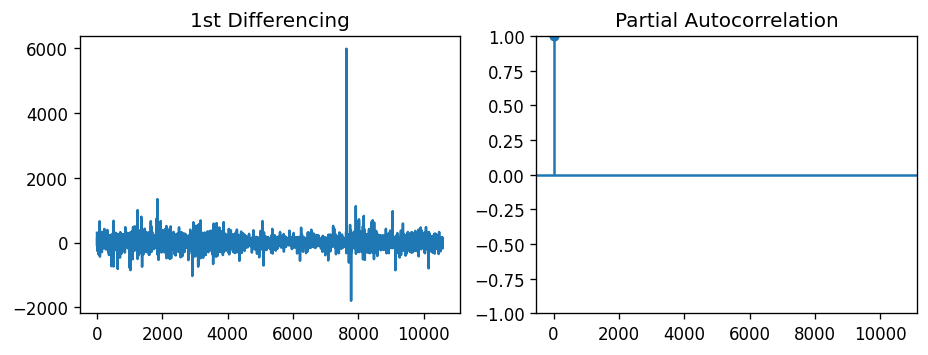

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train.diff(), ax=axes[1])

plt.show()

In [ ]:
# p = 1

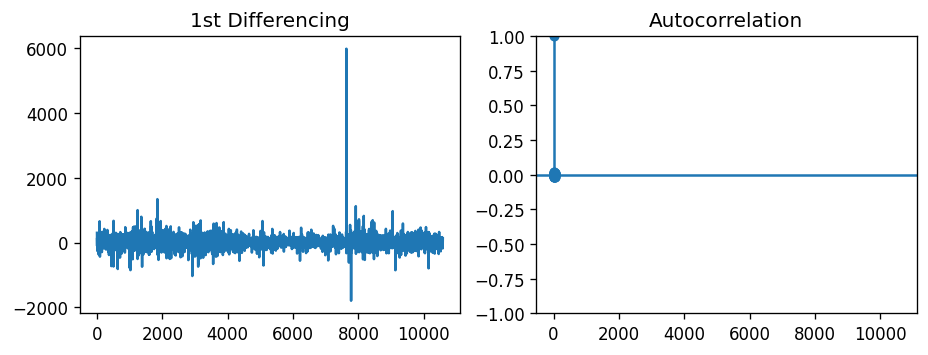

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train.diff().dropna(), ax=axes[1])

plt.show()

q = 1

In [ ]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 40.1 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=134430.902, Time=1.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=134427.000, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=134428.901, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=134428.899, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=134425.725, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.240 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10584
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -67211.862
Date:                Sun, 04 Jun 2023   AIC                         134425.725
Time:                        21:52:32   BIC                         134432.992
Sample:                             0   HQIC                        134428.178
                              - 10584                             

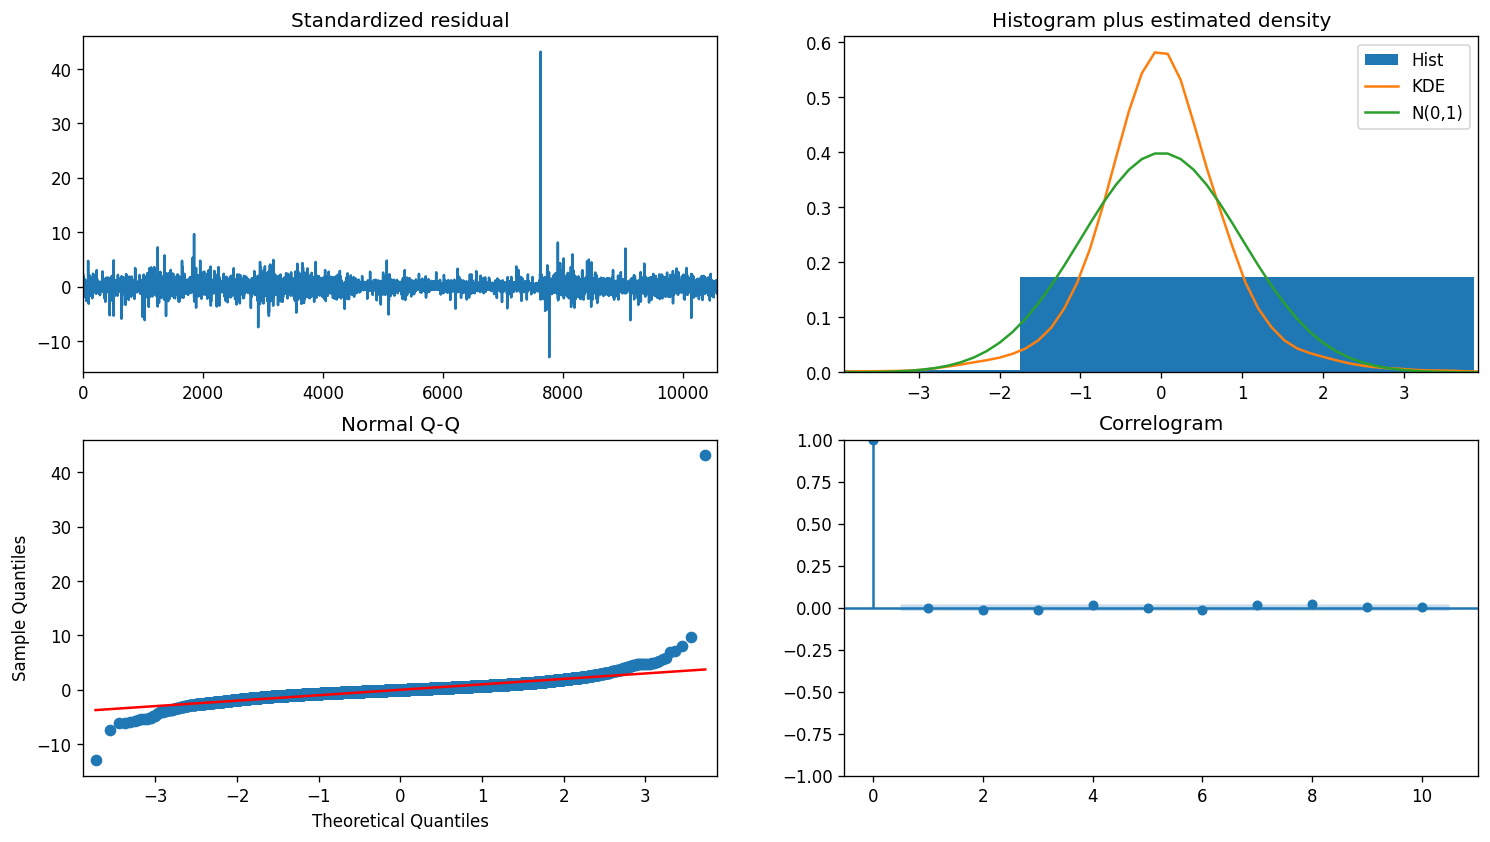

In [ ]:
model_autoARIMA = auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Build Model
alpha = 0.1
model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit()  

forecast = fitted.get_forecast(100)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=alpha)

In [ ]:
def train_pred(alpha, train):
  model = ARIMA(train, order=(0, 1, 0))  
  fitted = model.fit()
  forecast = fitted.get_forecast(1)
  yhat = forecast.predicted_mean
  yhat_conf_int = forecast.conf_int(alpha=alpha)
  return yhat, yhat_conf_int

In [ ]:
from tqdm import tqdm
interval = 1
alpha = 0.1
Yhat = []
lower = []
upper = []
Train = list(train.values)
for i in tqdm(range(len(test))):
  yhat, yhat_conf_int = train_pred(alpha, Train)
  Yhat.append(yhat[0])
  lower.append(yhat_conf_int[0,0])
  upper.append(yhat_conf_int[0,1])
  Train.append(test.values[i])

100%|██████████| 4536/4536 [15:10<00:00,  4.98it/s]


In [ ]:
out = pd.DataFrame()
out["lower"] = lower
out["upper"] = upper
out["pred"] = Yhat
out.index = test.index
out

,lower,upper,pred
10584,49174.348637,49630.461363,49402.405
10585,49199.949043,49656.040957,49427.995
10586,49047.226744,49503.323256,49275.275
10587,48973.794493,49429.875507,49201.835
10588,48929.804177,49385.865823,49157.835
...,...,...,...
15115,42753.589772,43235.180228,42994.385
15116,42613.770471,43095.359529,42854.565
15117,42708.885073,43190.464927,42949.675
15118,42640.551302,43122.118698,42881.335


In [ ]:
out.to_csv("arima_results010.csv")

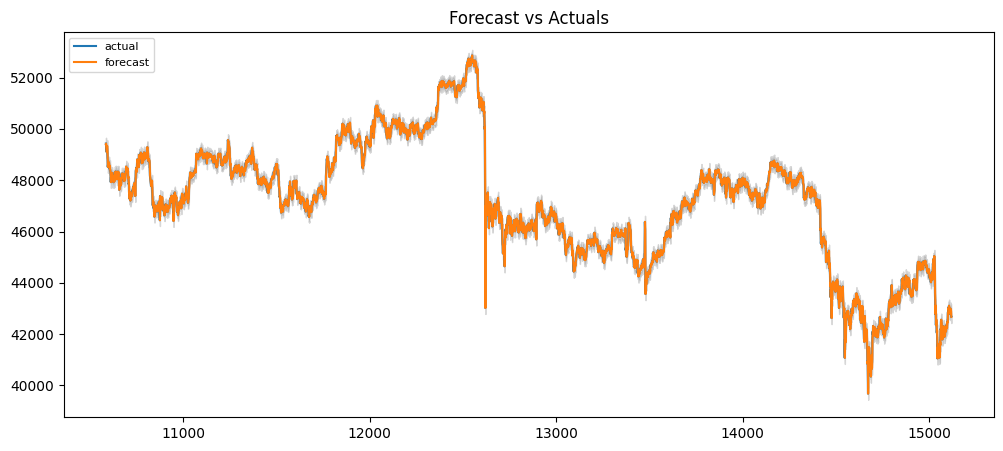

In [ ]:
# Make as pandas series
fc_series = pd.Series(Yhat, index = test.index)
lower_series = pd.Series(lower, index = test.index)
upper_series = pd.Series(upper, index = test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
def coverage(y: np.ndarray, pred_low: np.ndarray, pred_high: np.ndarray) -> float:
    """Calculates coverage.

    Args
    - y: array of shape [n], labels
    - pred_low: array of shape [n], predicted (α/2)-quantile
    - pred_high: array of shape [n], predicted (1-α/2)-quantile

    Returns: float, coverage rate
    """
    assert len(y) == len(pred_low)
    assert len(y) == len(pred_high)
    ##### YOUR CODE HERE (~1 line) #####
    cov = 0

    for i in range(len(y)):
      if y[i] >= pred_low[i] and y[i] <= pred_high[i]:
        cov += 1
    cov = cov / len(y)
    ##### END YOUR CODE #####
    return cov

In [ ]:
print(coverage(np.array(test[1000:]), lower[1000:], upper[1000:]))

0.9349547511312217


In [ ]:
def nonconformity_score(y: np.ndarray, q_low: np.ndarray, q_high: np.ndarray) -> np.ndarray:
    """Calculates nonconformity score for conformalized quantile regression.

    Args
    - y: array of shape [n], labels
    - q_low: array of shape [n], predicted (α/2)-quantile
    - q_high: array of shape [n], predicted (1-α/2)-quantile

    Returns: array of shape [n], nonconformity scores
    """
    ##### YOUR CODE HERE (~1 line) #####
    scores = []
    for i in range(len(y)):
      score = max(q_low[i] - y[i], y[i] - q_high[i])
      scores.append(score)
    return scores
    ##### END YOUR CODE #####
    


def cqr(test, low, high, alpha) -> tuple[np.ndarray, np.ndarray]:
    """Performs conformal calibration and returns the prediction intervals.

    Args
    - qr_low, qr_high: sklearn QuantileRegressor models for predicting
        low / high quantiles, respectively
    - X_cal: array of shape [n, d], calibration set features
    - y_cal: array of shape [n], calibration set labels
    - alpha: float, desired error rate
    - test_pred_low, test_pred_high: arrays of shape [n_test], uncalibrated
        predicted quantiles on the test set

    Returns: (pred_low, pred_high), calibrated lower and upper quantiles
    """
    # 1. Call the nonconformity_score() function to calculate nonconformity scores
    #      on the calibration set
    # 2. Set qhat to be the ceil((n+1)*(1-alpha))/n quantile of the nonconformity scores
    # 3. Adjust the calibration intervals as
    #      C(x) = [t_{α/2}(x) − qhat, t_{1−α/2}(x) + qhat]

    ##### YOUR CODE HERE (~6 lines) #####
    n = 1000
    y_cal = test[:n]
    low_cal = low[:n]
    high_cal = high[:n]

    s = nonconformity_score(y_cal, low_cal, high_cal)
    qhat = np.quantile(s, np.ceil((n+1) * (1- alpha))/n)
    pred_low = low - qhat
    pred_high = high + qhat
    
    
    ##### END YOUR CODE #####
    return (pred_low[1000:], pred_high[1000:])

In [ ]:
calibrated_y_pred_low, calibrated_y_pred_high = cqr(
    np.array(test),df["lower"].values, df["upper"].values, alpha)

# check post-calibration coverage
print(coverage(np.array(test[1000:]), calibrated_y_pred_low, calibrated_y_pred_high))

0.8891402714932126


In [ ]:
# Make as pandas series
fc_series = pd.Series(Yhat[1000:], index=test.index[1000:])
lower_series = pd.Series(calibrated_y_pred_low, index=test.index[1000:])
upper_series = pd.Series(calibrated_y_pred_high, index=test.index[1000:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test.index[1000:1100], test[1000:1100], label='actual')
plt.plot(test.index[1000:1100], fc_series[:100], label='forecast')
plt.fill_between(lower_series.index[:100], lower_series[:100], upper_series[:100], 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: ignored

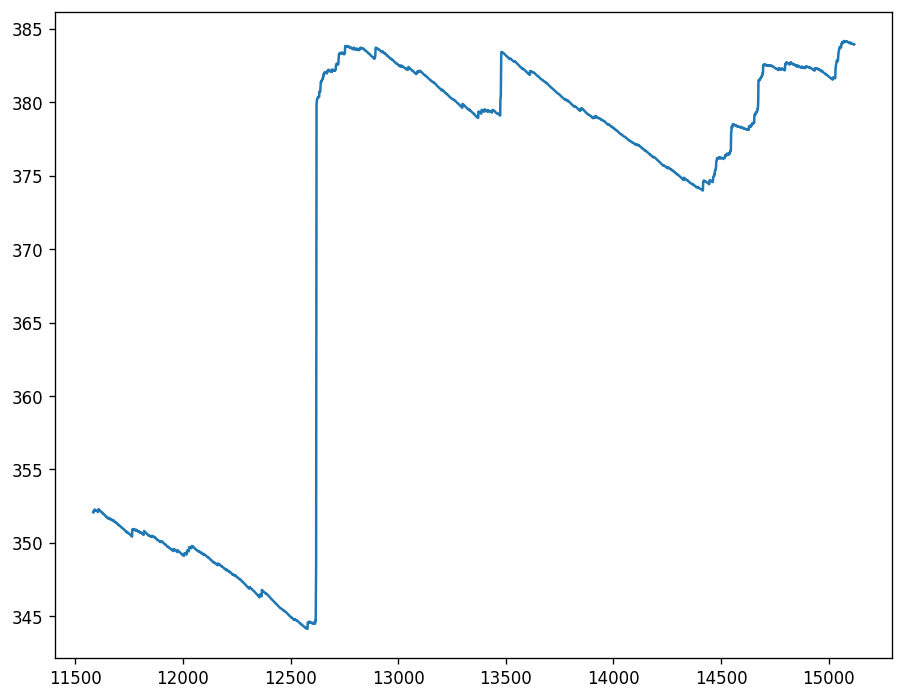

In [ ]:
plt.plot(upper_series - lower_series)

In [ ]:
out2 = pd.DataFrame()
out2["lower"] = calibrated_y_pred_low
out2["upper"] = calibrated_y_pred_high
out2["pred"] = Yhat[1000:]
out2.index = test.index[1000:]
out2

,lower,upper,pred
11584,47169.427636,47521.502364,47345.465
11585,47093.274328,47445.335672,47269.305
11586,47457.335191,47809.514809,47633.425
11587,47243.621190,47595.828810,47419.725
11588,47199.139868,47551.330132,47375.235
...,...,...,...
15115,42802.405102,43186.364898,42994.385
15116,42662.585801,43046.544199,42854.565
15117,42757.700404,43141.649596,42949.675
15118,42689.366632,43073.303368,42881.335


In [ ]:
out2.to_csv("conformal_results010.csv")

In [ ]:
def confidence_interval_gap(upper, lower):
    return upper - lower 

def confidence_interval_change(upper, lower, std):
    #The lower the better 
    delta_ci = upper - lower 
    diff = []
    for i in range(upper.keys().start, upper.keys().stop-1):
        num = delta_ci.loc[i+1] - delta_ci.loc[i]
        denom = std.loc[i+1] - std.loc[i]
        diff.append(num/denom)
    return -1 * sum(diff)

def expected_value_of_ci_change(upper, lower, std):
    #Put emphasis on the region of confidence interval that have large variance, and exaime the gap
    #The better ci is one that have small difference in places where the variance is high
    delta_ci = upper - lower 
    exp = []
    normalization = 0
    for i in range(upper.keys().start, upper.keys().stop-1):
        exp.append(delta_ci.loc[i] * std.loc[i])
        normalization += std.loc[i]
    return np.array(exp)/normalization 

In [ ]:
df = pd.read_csv('drive/MyDrive/arima_results010.csv')

In [ ]:
times = data.iloc[split:].iloc[1000:1145:3]["threshold_time_ms"].values

In [ ]:
hours = [s[6:-3] for s in times]
hours

['8-31 10:40',
 '8-31 11:10',
 '8-31 11:40',
 '8-31 12:10',
 '8-31 12:40',
 '8-31 13:10',
 '8-31 13:40',
 '8-31 14:10',
 '8-31 14:40',
 '8-31 15:10',
 '8-31 15:40',
 '8-31 16:10',
 '8-31 16:40',
 '8-31 17:10',
 '8-31 17:40',
 '8-31 18:10',
 '8-31 18:40',
 '8-31 19:10',
 '8-31 19:40',
 '8-31 20:10',
 '8-31 20:40',
 '8-31 21:10',
 '8-31 21:40',
 '8-31 22:10',
 '8-31 22:40',
 '8-31 23:10',
 '8-31 23:40',
 '9-01 00:10',
 '9-01 00:40',
 '9-01 01:10',
 '9-01 01:40',
 '9-01 02:10',
 '9-01 02:40',
 '9-01 03:10',
 '9-01 03:40',
 '9-01 04:10',
 '9-01 04:40',
 '9-01 05:10',
 '9-01 05:40',
 '9-01 06:10',
 '9-01 06:40',
 '9-01 07:10',
 '9-01 07:40',
 '9-01 08:10',
 '9-01 08:40',
 '9-01 09:10',
 '9-01 09:40',
 '9-01 10:10',
 '9-01 10:40']

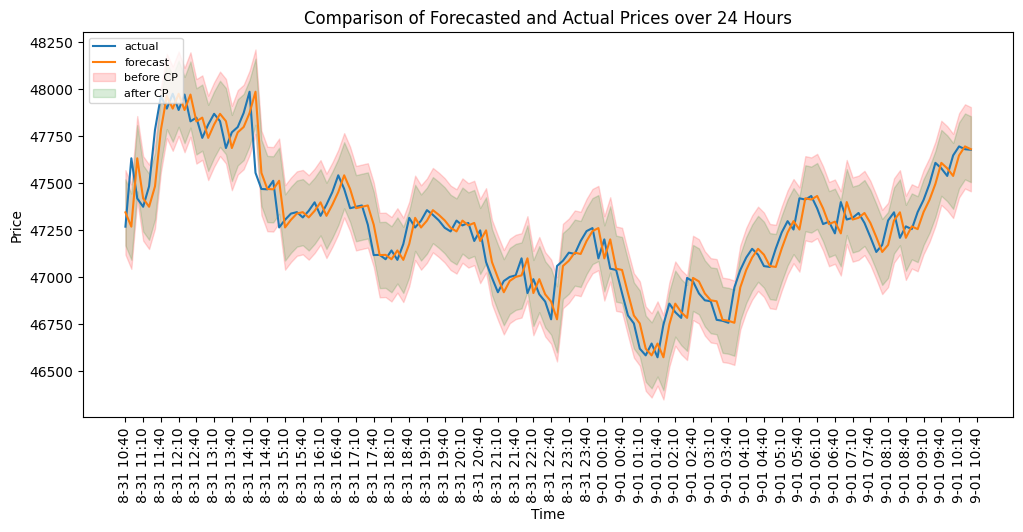

In [ ]:
import matplotlib.pyplot as plt
# Make as pandas series
fc_series = pd.Series(df["pred"].values[1000:], index=test.index[1000:])
lower_series = pd.Series(df["lower"].values[1000:], index=test.index[1000:])
upper_series = pd.Series(df["upper"].values[1000:], index=test.index[1000:])

lower_seriesCP = pd.Series(calibrated_y_pred_low, index=test.index[1000:])
upper_seriesCP = pd.Series(calibrated_y_pred_high, index=test.index[1000:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test.index[1000:1144], test[1000:1144], label='actual')
plt.plot(test.index[1000:1144], fc_series[:144], label='forecast')



plt.fill_between(lower_series.index[:144], lower_series[:144], upper_series[:144], 
                 color='red', alpha=.15, label = "before CP")

plt.fill_between(lower_series.index[:144], lower_seriesCP[:144], upper_seriesCP[:144], 
                 color='green', alpha=.15, label = "after CP")

plt.xlabel("Time")
plt.ylabel("Price")
plt.title('Comparison of Forecasted and Actual Prices over 24 Hours')
plt.xticks(test.index[1000:1145:3], hours,
       rotation=90) 
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(coverage(np.array(test[1000:]), df["lower"].values[1000:], df["upper"].values[1000:]))

0.9349547511312217


In [ ]:
calibrated_y_pred_low, calibrated_y_pred_high = cqr(
    np.array(test), df["lower"].values, df["upper"].values, 0.1)

# check post-calibration coverage
print(coverage(np.array(test[1000:]), calibrated_y_pred_low, calibrated_y_pred_high))

0.8959276018099548


In [ ]:
import matplotlib.pyplot as plt
# Make as pandas series
fc_series = pd.Series(df["pred"].values[1000:], index=test.index[1000:])
lower_series = pd.Series(df["lower"].values[1000:], index=test.index[1000:])
upper_series = pd.Series(df["upper"].values[1000:], index=test.index[1000:])

# Plot
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train, label='training')
plt.plot(test.index[1000:1100], test[1000:1100], label='actual')
plt.plot(test.index[1000:1100], fc_series[:100], label='forecast')
plt.fill_between(lower_series.index[:100], lower_series[:100], upper_series[:100], 
                 color='k', alpha=.15, label = "before CP")
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
df = pd.read_csv('drive/MyDrive/arima_results.csv')

In [ ]:
df

,Unnamed: 0,lower,upper,pred
0,10584,49175.990468,49676.012973,49426.001721
1,10585,49226.726297,49726.725176,49476.725737
2,10586,49038.722923,49538.739718,49288.731320
3,10587,48947.691246,49447.692224,49197.691735
4,10588,48885.892797,49385.871795,49135.882296
...,...,...,...,...
4531,15115,42762.466542,43290.738900,43026.602721
4532,15116,42567.743175,43096.018135,42831.880655
4533,15117,42714.767306,43243.034173,42978.900739
4534,15118,42644.560074,43172.815880,42908.687977


In [ ]:
# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
K=1000; weights = np.ones((K,)); # Take a fixed window of K
wtildes = weights/(weights.sum() + 1)

In [ ]:
from scipy.optimize import brentq

In [ ]:
pred_mean = df["pred"]
temperatures = test.values


4536
4536


In [ ]:
def nonconformity_score(y: np.ndarray, q_low: np.ndarray, q_high: np.ndarray) -> np.ndarray:
    """Calculates nonconformity score for conformalized quantile regression.

    Args
    - y: array of shape [n], labels
    - q_low: array of shape [n], predicted (α/2)-quantile
    - q_high: array of shape [n], predicted (1-α/2)-quantile

    Returns: array of shape [n], nonconformity scores
    """
    ##### YOUR CODE HERE (~1 line) #####
    scores = []
    for i in range(len(y)):
      score = max(q_low[i] - y[i], y[i] - q_high[i])
      scores.append(score)
    return scores
    ##### END YOUR CODE #####
    


def cqr(test, low, high, alpha) -> tuple[np.ndarray, np.ndarray]:
    """Performs conformal calibration and returns the prediction intervals.

    Args
    - qr_low, qr_high: sklearn QuantileRegressor models for predicting
        low / high quantiles, respectively
    - X_cal: array of shape [n, d], calibration set features
    - y_cal: array of shape [n], calibration set labels
    - alpha: float, desired error rate
    - test_pred_low, test_pred_high: arrays of shape [n_test], uncalibrated
        predicted quantiles on the test set

    Returns: (pred_low, pred_high), calibrated lower and upper quantiles
    """
    # 1. Call the nonconformity_score() function to calculate nonconformity scores
    #      on the calibration set
    # 2. Set qhat to be the ceil((n+1)*(1-alpha))/n quantile of the nonconformity scores
    # 3. Adjust the calibration intervals as
    #      C(x) = [t_{α/2}(x) − qhat, t_{1−α/2}(x) + qhat]

    ##### YOUR CODE HERE (~6 lines) #####
    n = 1000
    y_cal = test[:n]
    low_cal = low[:n]
    high_cal = high[:n]

    s = nonconformity_score(y_cal, low_cal, high_cal)
    qhat = np.quantile(s, np.ceil((n+1) * (1- alpha))/n)
    pred_low = low - qhat
    pred_high = high + qhat
    
    
    ##### END YOUR CODE #####
    return (pred_low[1000:], pred_high[1000:])

In [ ]:
scores = nonconformity_score(df["pred"], df["lower"], df["upper"])
T = 1000
sum([scores[T-K:T][i] <= 100 for i in range(K)])

1000

In [ ]:
# Use the uncertainty scalars method to get conformal scores
K = 100
scores = nonconformity_score(test.values, df["lower"], df["upper"])
# Get the weighted score quantile at each time step
def get_weighted_quantile(scores,T):
    score_window = scores[T-K:T]
    qhat = np.quantile(score_window, np.ceil((K+1) * (1- alpha))/K)
    return qhat

qhats = np.array( [get_weighted_quantile(scores, t) for t in range(K, len(scores))] )
lower, upper = (df["lower"][K:] - qhats, df["upper"][K:] + qhats)

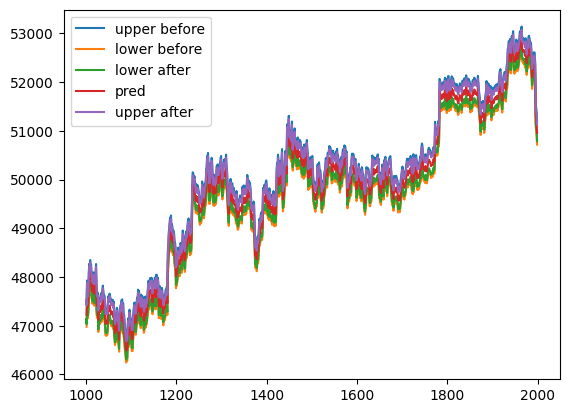

In [ ]:
plt.plot(df["upper"][K+1:2*K], label = "upper before")
plt.plot(df["lower"][K+1:2*K], label = "lower before")
plt.plot(lower[:K], label = "lower after")
plt.plot(df["pred"][K+1:2*K], label = "pred")
plt.plot(upper[:K], label = "upper after")
plt.legend()

In [ ]:
test = [df["lower"][K+1:] - qhats, df["upper"][K+1:] + qhats]

In [ ]:
print(coverage(np.array(test[1000:]), df["lower"].values[1000:], df["upper"].values[1000:]))

0.9301470588235294


In [ ]:
print(coverage(np.array(test[100:]), lower.values, upper.values))

0.9023895401262398


In [ ]:
len(lower[900:].values)

3536

In [ ]:
len(test[1000:])

3536

In [ ]:
len(df["lower"])

4536

In [ ]:
C = []
C1 = []
C2 = []
window = 500
for i in range(len(test) - 1000 - window):
  print()
  C1.append(coverage(np.array(test[1000 + i: 1000 + i + window]), calibrated_y_pred_low[i:i + window], calibrated_y_pred_high[i:i + window]))

  C.append(coverage(np.array(test[1000 + i: 1000 + i + window]), lower.values[900 + i: 900 + i + window], upper.values[900 + i: 900+i+window]))

  C2.append(coverage(np.array(test[1000 + i: 1000 + i + window]), df["lower"].values[1000 + i: 1000 + i + window], df["upper"].values[1000 + i: 1000 + i + window]))

In [ ]:
for i in range(0, len(test) - 1000 - window):
  print(i)
  break

In [ ]:
i

4535

In [ ]:
len(test)

4536

In [ ]:
test[1000 + i: 1000 + i + window]

Series([], Name: value, dtype: float64)

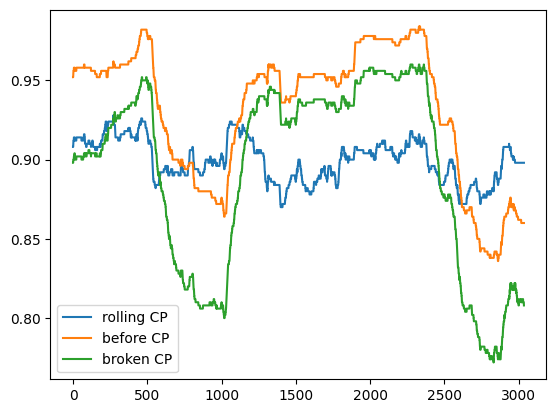

In [ ]:
plt.plot(C, label = "rolling CP")
plt.plot(C2, label = "before CP")
plt.plot(C1, label = "broken CP")
plt.legend()

In [ ]:
 lower.values

array([47325.0304734 , 47225.93803069, 47682.33721455, ...,
       42973.95201443, 42903.74478312, 42610.88060679])

In [ ]:
upper.values

array([47324.14532   , 47225.04117787, 47681.58520265, ...,
       42983.84946452, 42913.63117128, 42620.78743504])

In [ ]:
bnn = pd.read_csv("bnn_results-1.csv")

In [ ]:
bnn

,threshold_time_ms,lower,upper,pred
0,2021-08-24 16:50:00,44963.816,50035.113,48182.060
1,2021-08-24 17:00:00,44938.080,50005.800,48153.710
2,2021-08-24 17:10:00,44881.080,49942.703,48095.380
3,2021-08-24 17:20:00,44863.227,49918.210,48073.570
4,2021-08-24 17:30:00,44846.070,49897.234,48054.215
...,...,...,...,...
4501,2021-09-24 23:00:00,39830.240,44290.700,42668.965
4502,2021-09-24 23:10:00,39839.790,44299.260,42677.610
4503,2021-09-24 23:20:00,39831.566,44292.848,42670.600
4504,2021-09-24 23:30:00,39794.406,44252.023,42630.920


In [ ]:
pd.Timestamp('2021-08-24T16:50:00')

Timestamp('2021-08-24 16:50:00')

In [ ]:
data.iloc[10584 + 29]

threshold_time_ms    2021-08-24 16:50:00
open                           47953.895
close                          47943.125
high                           48091.995
low                            47850.535
mean                        47970.372654
Name: 10613, dtype: object

In [ ]:
data.iloc[-2]

threshold_time_ms    2021-09-24 23:40:00
open                           42672.665
close                          42687.125
high                           42746.715
low                            42518.375
mean                        42682.211311
Name: 15118, dtype: object

In [ ]:
test.iloc[29:-1]

10613    47953.895
10614    47943.315
10615    48124.875
10616    48286.585
10617    48213.945
           ...    
15114    42994.385
15115    42854.565
15116    42949.675
15117    42881.335
15118    42672.665
Name: value, Length: 4506, dtype: float64

In [ ]:
ARIMA = 

0        2021-06-01 00:00:00
1        2021-06-01 00:10:00
2        2021-06-01 00:20:00
3        2021-06-01 00:30:00
4        2021-06-01 00:40:00
                ...         
15115    2021-09-24 23:10:00
15116    2021-09-24 23:20:00
15117    2021-09-24 23:30:00
15118    2021-09-24 23:40:00
15119    2021-09-24 23:50:00
Name: threshold_time_ms, Length: 15120, dtype: object

In [ ]:
allData = pd.DataFrame()
allData["true y"] = test.iloc[29:-1].values
allData["arima pred"] = df["pred"][29:-1].values
allData["arima low before cp"] = df["lower"][29:-1].values
allData["arima high before cp"] = df["upper"][29:-1].values

allData["bnn pred"] = bnn["pred"]
allData["bnn low before cp"] = bnn["lower"]
allData["bnn high before cp"] = bnn["upper"]

In [ ]:
allData

,true y,arima pred,arima low before cp,arima high before cp,bnn pred,bnn low before cp,bnn high before cp
0,47953.895,48092.058972,47842.059768,48342.058176,48182.060,44963.816,50035.113
1,47943.315,47872.890330,47622.893180,48122.887480,48153.710,44938.080,50005.800
2,48124.875,47888.805816,47638.817927,48138.793705,48095.380,44881.080,49942.703
3,48286.585,48167.671676,47917.667045,48417.676308,48073.570,44863.227,49918.210
4,48213.945,48318.118456,48068.118382,48568.118530,48054.215,44846.070,49897.234
...,...,...,...,...,...,...,...
4501,42994.385,42960.344730,42696.200210,43224.489249,42668.965,39830.240,44290.700
4502,42854.565,43026.602721,42762.466542,43290.738900,42677.610,39839.790,44299.260
4503,42949.675,42831.880655,42567.743175,43096.018135,42670.600,39831.566,44292.848
4504,42881.335,42978.900739,42714.767306,43243.034173,42630.920,39794.406,44252.023


In [ ]:
# Use the uncertainty scalars method to get conformal scores
def conformal(df, model, K):
  def get_weighted_quantile(scores,T):
      score_window = scores[T-K:T]
      
      qhat = np.quantile(score_window, np.ceil((K+1) * (1- alpha))/K)
      return qhat
  
  scores = nonconformity_score(df["true y"].values, df[f"{model} low before cp"].values, df[f"{model} high before cp"].values)
# Get the weighted score quantile at each time step
  qhats = np.array( [get_weighted_quantile(scores, t) for t in range(K, len(scores))] )
  df[f"{model} low after rolling cp"] = df[f"{model} low before cp"][K:] - qhats
  df[f"{model} high after rolling cp"] = df[f"{model} high before cp"][K:] + qhats
 

  

In [ ]:
# Use the uncertainty scalars method to get conformal scores
def broken_conformal(df, model, K):
  
  
  scores = nonconformity_score(df["true y"].values, df[f"{model} low before cp"].values, df[f"{model} high before cp"].values)
# Get the weighted score quantile at each time step
  qhats = np.quantile(scores, np.ceil((K+1) * (1- alpha))/K)
  df[f"{model} low after bad cp"] = df[f"{model} low before cp"][K:] - qhats
  df[f"{model} high after bad cp"] = df[f"{model} high before cp"][K:] + qhats
 

  

In [ ]:
conformal(allData, "arima", 100)
conformal(allData, "bnn", 100)

In [ ]:
broken_conformal(allData, "arima", 1000)
broken_conformal(allData, "bnn", 1000)

In [ ]:
allData = allData.dropna()

In [3]:
allData

,Unnamed: 0,true y,arima pred,arima low before cp,arima high before cp,bnn pred,bnn low before cp,bnn high before cp,arima low after rolling cp,arima high after rolling cp,bnn low after rolling cp,bnn high after rolling cp,arima low after bad cp,arima high after bad cp,bnn low after bad cp,bnn high after bad cp
0,1000,47346.615,47315.350283,47068.755418,47561.945147,47296.770,44134.960,49101.810,47101.126399,47529.574167,45371.74429,47865.02571,47112.799934,47517.900631,45373.382835,47863.387165
1,1001,47318.435,47315.992748,47069.408047,47562.577449,47218.836,44060.645,49023.277,47101.779028,47530.206469,45297.42929,47786.49271,47113.452563,47518.532934,45299.067835,47784.854165
2,1002,47353.605,47280.592777,47034.018694,47527.166861,47202.430,44044.477,49006.297,47066.389674,47494.795881,45281.26129,47769.51271,47078.063210,47483.122345,45282.899835,47767.874165
3,1003,47398.955,47372.212974,47125.646973,47618.778974,47179.980,44023.395,48983.293,47158.017953,47586.407994,45260.17929,47746.50871,47169.691489,47574.734458,45261.817835,47744.870165
4,1004,47326.995,47417.467005,47170.911284,47664.022727,47178.996,44020.940,48981.445,47203.282264,47631.651746,45257.72429,47744.66071,47214.955800,47619.978211,45259.362835,47743.022165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3501,4501,42994.385,42960.344730,42696.200210,43224.489249,42668.965,39830.240,44290.700,42550.165079,43370.524380,40833.11431,43287.82569,42740.244726,43180.444733,41068.662835,43052.277165
3502,4502,42854.565,43026.602721,42762.466542,43290.738900,42677.610,39839.790,44299.260,42616.431410,43436.774032,40842.66431,43296.38569,42806.511058,43246.694384,41078.212835,43060.837165
3503,4503,42949.675,42831.880655,42567.743175,43096.018135,42670.600,39831.566,44292.848,42421.708043,43242.053267,40834.44031,43289.97369,42611.787691,43051.973619,41069.988835,43054.425165
3504,4504,42881.335,42978.900739,42714.767306,43243.034173,42630.920,39794.406,44252.023,42568.732174,43389.069305,40797.28031,43249.14869,42758.811822,43198.989657,41032.828835,43013.600165


In [ ]:
print(coverage(allData["true y"].values, allData["arima low before cp"].values, allData["arima high before cp"].values))

0.9306902452937821


In [ ]:
print(coverage(allData["true y"].values, allData["bnn low before cp"].values, allData["bnn high before cp"].values))

0.9997147746719909


In [ ]:
print(coverage(allData["true y"].values, allData["arima low after rolling cp"].values, allData["arima high after rolling cp"].values))

0.9018824871648602


In [ ]:
print(coverage(allData["true y"].values, allData["bnn low after rolling cp"].values, allData["bnn high after rolling cp"].values))

0.8873359954363947


In [ ]:
print(coverage(allData["true y"].values, allData["bnn low after bad cp"].values, allData["bnn high after bad cp"].values))


0.8884768967484312


In [ ]:
allData.to_csv("allData.csv")

In [2]:
import pandas as pd
allData = pd.read_csv("allData.csv")

In [ ]:

C = []
C1 = []
C2 = []
window = 500
for i in range(len(test) - 1000 - window):
  print()
  C1.append(coverage(np.array(test[1000 + i: 1000 + i + window]), calibrated_y_pred_low[i:i + window], calibrated_y_pred_high[i:i + window]))

  C.append(coverage(np.array(test[1000 + i: 1000 + i + window]), lower.values[900 + i: 900 + i + window], upper.values[900 + i: 900+i+window]))

  C2.append(coverage(np.array(test[1000 + i: 1000 + i + window]), df["lower"].values[1000 + i: 1000 + i + window], df["upper"].values[1000 + i: 1000 + i + window]))

In [ ]:
def coverageplot(model):
  badcp = []
  goodcp= []
  nocp = []
  window = 500
  for i in range(len(allData) - window):
    badcp.append(coverage(allData["true y"][i : i + window].values, allData[f"{model} low after bad cp"][i : i + window].values, allData[f"{model} high after bad cp"][i : i + window].values))
    goodcp.append(coverage(allData["true y"][i : i + window].values, allData[f"{model} low after rolling cp"][i : i + window].values, allData[f"{model} high after rolling cp"][i : i + window].values))
    nocp.append(coverage(allData["true y"][i : i + window].values, allData[f"{model} low before cp"][i : i + window].values, allData[f"{model} high before cp"][i : i + window].values))
  plt.plot(badcp, label = "Bad CP")
  plt.plot(nocp, label = "No CP")
  plt.plot(goodcp, label = "Good CP")
  plt.legend()

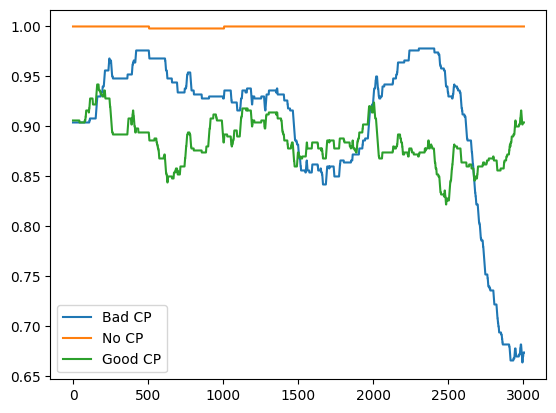

In [ ]:
coverageplot("bnn")

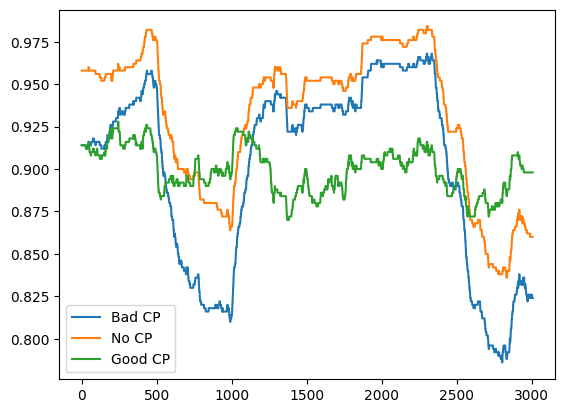

In [ ]:
coverageplot("arima")


In [1]:
coverageplot("arima")

NameError: ignored